This notebook was developed as a starting point in the analysis of the results of the bathymetry and bottomfriction calibration. Let us start my importing some modules

In [1]:
import os
import sys
sys.path.append('/u/vasulkar/p_emodnet_amey/Regional_canada_model/')
path1=sys.path[-1]
print(path1)
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cpf
import pandas as pd
import xarray as xr
from postprocessing import readdata, tideanalysis
from shapely.geometry import Polygon, Point, MultiPolygon, shape
import seaborn as sns
# sns.set_theme("notebook") 

/u/vasulkar/p_emodnet_amey/Regional_canada_model/


We try to compare different runs of optimization first and then compare to FES and GTSM. Now, the first step is to plot the cost function graph.

First step is reading the correct obs.

In [2]:
def readnprocessobsdata(tgstafile,obsfolder):   
    headerlist=["Lon","Lat","Name"]
    df=pd.read_csv(tgstafile,delim_whitespace=True,names=headerlist,quotechar="'")
    tstaposdata=np.vstack((df['Lon'],df['Lat'])).T
    tstanamdata=np.array(df['Name'])
    files=os.listdir(obsfolder)
    headerlist=["Time","Waterlevel"]
    for i in range(len(tstanamdata)):
        tgfile=obsfolder+'/'+tstanamdata[i]+'.wl'
        if i==0:
            dftg=pd.read_csv(tgfile,delim_whitespace=True,names=headerlist,skiprows=1)
            hmattg=dftg['Waterlevel']
        else:
            dftg=pd.read_csv(tgfile,delim_whitespace=True,names=headerlist,skiprows=1)
            hmattg=np.vstack((hmattg,dftg['Waterlevel']))
    #station data
    Lonvec=df['Lon']
    Latvec=df['Lat']
    return(hmattg,Lonvec,Latvec)

# tgstafile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/snelliusmodels/Canadamodel_1/stochModel/input_model/TGObs_Sep.xyn' #file which has obs on wet cells in canada model.
tgstafile='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/snelliusmodels/Canadamodel_4.1r/stochModel/input_model/TGObs_Sep.xyn'
#TG obs from the obs folder.
obsfolder=os.path.join(path1,'model_development','Openda_models','Observations','CHSTG','Sept_All')
(hobs,Lonvec,Latvec)=readnprocessobsdata(tgstafile,obsfolder)

In [3]:
def plotcostfunction(resultsfile,fname):
    df=pd.read_csv(resultsfile,delimiter='\t',quotechar="'")
    # df.head()
    key=df.keys()
    costfuncvec=df[key[0]]
    index=np.linspace(0,len(costfuncvec),len(costfuncvec)+1)
    plt.plot(index[:-3],costfuncvec[:-2])
    plt.xlabel('Iterations')
    plt.ylabel('Cost function value')   
    plt.savefig(fname,dpi=300)

import math
def rmscompute(hobs,hmod):
    #first remove the mean from hobs.
    hobsmean=hobs-hobs.mean()
    hmodmean=hmod-hmod.mean()
    MSE = np.square(np.subtract(hobsmean,hmodmean)).mean() 
    RMSE = math.sqrt(MSE)
    return(RMSE)

def getrmsdata(hobsmat,hmodmat):
    nstations=len(hobsmat[:,0])
    rmsevec=[]
    for i in range(nstations):
        RMSE=rmscompute(hobsmat[i,:],hmodmat[i,:])
        rmsevec=np.append(rmsevec,RMSE)
    return(rmsevec)

def getrunoutputdata(simfolder,optworkdir):
    optmodelfolder=simfolder+'stochModel/work'+optworkdir+'/'
    #reading the optimal results.
    optmoddata=xr.open_dataset(optmodelfolder+'output/canada_model_0000_his.nc')
    return(optmoddata,optmodelfolder)
    
def readparameter(optmodelfolder,paramfilename,templateparamfilename):
    paramfile=optmodelfolder+paramfilename
    # print(paramfile)
    tempparafile=optmodelfolder+templateparamfilename
    plon=np.loadtxt(paramfile,usecols=0)
    plat=np.loadtxt(paramfile,usecols=1)
    param=np.loadtxt(paramfile,usecols=2) 
    tempparam=np.loadtxt(tempparafile,usecols=2)
    #bathy %change
    perparamchange=(param-1)*100.
    return(perparamchange,tempparam,plon,plat)

def processruns(runsfolder,simulationame,CFfname,optworkdir,paramfilename,templateparamfilename):
    # simfolder='Canadamodel_4.1.1'
    simfolder=runsfolder+'/'+simulationame+'/'
    fname=os.path.join(path1,'postprocessing','calibration','figures',CFfname)
    #plotting CF.
    resultsfile=simfolder+'results_dud.csv'
    plotcostfunction(resultsfile,fname)
    #get opt model data.

    (optmoddata,optmodelfolder)=getrunoutputdata(simfolder,optworkdir)
    #compute rmse stat
    hoptmodel=optmoddata['waterlevel'][1:,:] #1: because dflowfm saves the first time step and that time step is in spinup.
    canoptrmsevec=getrmsdata(hobs,hoptmodel.T)  
    #computing parameter:    
    (perparamchange,tempparam,plon,plat)=readparameter(optmodelfolder,paramfilename,templateparamfilename)
    # #time data
    # time=optmoddata['time']
    return(canoptrmsevec,perparamchange,tempparam,plon,plat)


def getparameterpolygon(poldf,Npol):
    Lonvec=poldf['X']
    Latvec=np.array(poldf['Y'])
    # Latvec[78]=72.0  ##it was 72.0033 changed as it is wrong in excel file
    # Latvec=np.where(Latvec==84,84.5,Latvec) ##points added till 84.3
    # Lonvec=np.where(Lonvec==-46.5,-46.0,Lonvec)
    idvec=poldf['id']
    vindexvec=poldf['vertex_index']
    polydict={}
    for id in range(Npol):
        id=id+1 #as the ids start from 1
        idindex=np.where(idvec==id)[0]
        coords=[]
        for i in range(len(idindex)):
            coords.append((Lonvec[idindex[i]],Latvec[idindex[i]]))
        poly=Polygon(coords)
        polydict[id]=poly
    return(polydict)

#plot rmse. 
def plotrmse(modrmse,Lonvec,Latvec,fname):
    from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
    # marking the x-axis and y-axis 
    fig=plt.figure(figsize=(12, 5), frameon=True)
    # proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
    proj=ccrs.PlateCarree()
    # ax1=fig.add_subplot(1,1,1,projection=proj) 
    ax1=plt.axes(projection=proj)
    ax1.set_extent((-145, -47, 49, 85), crs=ccrs.PlateCarree())
    feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
    ax1.add_feature(feature)
    cax = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.01,ax1.get_position().height])
    scatter_opts = {'marker':'^','s':300,'cmap':'viridis','transform':ccrs.PlateCarree(),'alpha':1,'vmin':0,'vmax':1.0}
    cont=ax1.scatter(Lonvec,Latvec,c=modrmse,**scatter_opts)
    cbar=plt.colorbar(cont,cax=cax)
    cbarlabel='Differences in m'
    cbar.set_label(cbarlabel)
    # plt.show() 
    # ax1.set_title('Difference in RMSE (blue showing improvement)', fontsize=20)
    fig.savefig(fname,dpi=300)
  

/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_runs/snellius_runs/OpenDAruns/2020runs


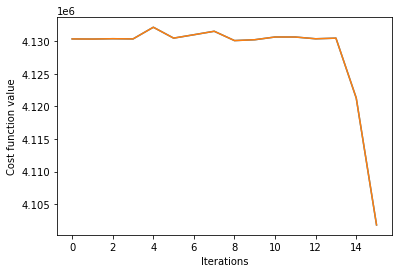

In [8]:
#function defintion. 
typ='vis'
runsfolder=os.path.join(path1,'model_runs','snellius_runs','OpenDAruns','2020runs')
print(runsfolder)
simulationame='Canadamodel_v1.1'
CFfname='CF_'+simulationame+'.jpg'
optworkdir=str(18)
if typ=='bathy':
    paramfilename='bathy_correction_20_v5.xyz'
    templateparamfilename='bathy_correction_template_20_v5.xyz'
    (modrmse_both_8r3,perparamchange_bathy,tempparam_bathy,plon_bathy,plat_bathy)=processruns(runsfolder,simulationame,CFfname,optworkdir,paramfilename,templateparamfilename)
    #mix15 bounds
elif typ=='bf':
    paramfilename='bf_correction_16_v4.xyz'
    templateparamfilename='bf_correction_template_16_v4.xyz'
    (modrmse_both_42r1,perparamchange_bf,tempparam_bf,plon_bf,plat_bf)=processruns(runsfolder,simulationame,CFfname,optworkdir,paramfilename,templateparamfilename)
else:
    paramfilename='viscosity_correction_13_v1.xyz'
    templateparamfilename='viscosity_correction_template_13_v1.xyz'
    (modrmse_both_42r1,perparamchange_vis,tempparam_vis,plon_vis,plat_vis)=processruns(runsfolder,simulationame,CFfname,optworkdir,paramfilename,templateparamfilename)
#standardmod rmse:
(stanmodrmse,perparamchange_bfs,tempparam_bfs,plon_bfs,plat_bfs)=processruns(runsfolder,simulationame,CFfname,str(2),paramfilename,templateparamfilename)
# rmsefname=os.path.join(path1,'postprocessing','calibration','figures','RMSEOPT_4.1r.1_Sep.jpg')
# plotrmse(modrmse_both_5r1,Lonvec,Latvec,rmsefname)

In [9]:
#batthy
# poldf=pd.read_csv('/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Parameters/Polygon_crreation/PolVertices_2.csv')
# poldf=pd.read_csv('/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Parameters/new_bathy_polygon/bathy_polygon_vertices.csv')
# poldf=pd.read_csv('/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Parameters/new_bathy_polygon/bahy_polygon_vertices_v3.csv')
# poldf=pd.read_csv('/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Parameters/new_bathy_polygon/bathypolygonvertices_v5.csv')
# # poldf.head()
# Npol=20
#bf
# poldf=pd.read_csv('/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Parameters/new_bf_polygon/bf_polygon_vertices_v4.csv')
# poldf.head()
# Npol=16
#vis
poldf=pd.read_csv('/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Icedata/ice_vis_polygon_20200917/ice_poly_v1.csv')
poldf.head()
Npol=13
polydict=getparameterpolygon(poldf,Npol)

In [10]:
# parameter plot.
def plotparamvalue(plon,plat,paramvalue,polydict,fname):
    # marking the x-axis and y-axis 
    fig=plt.figure(figsize=(12,5), frameon=True)
    # proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
    proj=ccrs.PlateCarree()
    ax1=fig.add_subplot(1,1,1,projection=proj) 
    ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
    scatter_opts = {'marker':'o','cmap':'seismic','transform':ccrs.PlateCarree(),'alpha':1,'vmin':-60.0,'vmax':60.0}
    cax = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.01,ax1.get_position().height])
    cont=ax1.scatter(plon,plat,c=paramvalue,**scatter_opts)
    cbar=fig.colorbar(cont,cax=cax)
    cbarlabel='% Change'
    cbar.set_label(cbarlabel)
    for keys in polydict:
        ax1.add_geometries([polydict[keys]],crs=ccrs.PlateCarree(),edgecolor='green',facecolor='None',label=keys)
        x=polydict[keys].centroid.x
        y=polydict[keys].centroid.y
        ax1.text(x, y, keys, color='green', size=15, ha='center', va='center', transform=ccrs.PlateCarree())
        #getting points in polygon. from paramid.
        # indparam=np.where(vec[2,:]==keys)[0]
        # print(vec)
        # ax1.scatter(vec[0,indparam],vec[1,indparam],transform=ccrs.PlateCarree(),label=str(keys))
    feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
    ax1.add_feature(feature)
    # plt.show()
    # plt.title('% Change bathymetry', fontsize=20)
    fig.savefig(fname,dpi=300)

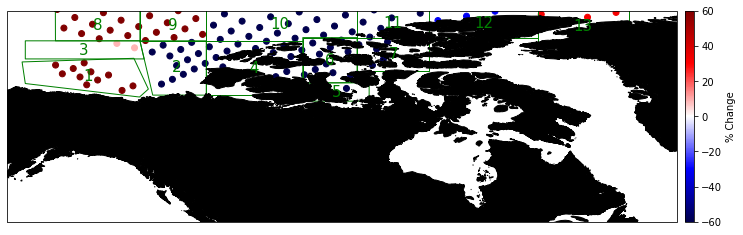

In [11]:
parafname=os.path.join(path1,'postprocessing','calibration','figures','viscorr_v1.1.jpg')
# plotparamvalue(plon_bf,plat_bf,perparamchange_bf,polydict,parafname)
# plotparamvalue(plon_bathy,plat_bathy,perparamchange_bathy,polydict,parafname)
plotparamvalue(plon_vis,plat_vis,perparamchange_vis,polydict,parafname)

In [70]:
sns.set_theme("paper") 
def plotrmsediff(modrmse1,modrmse2,Lonvec,Latvec,fname):
    from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
    diff=modrmse1-modrmse2
    # marking the x-axis and y-axis 
    fig=plt.figure(figsize=(12, 5), frameon=True)
    # proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
    proj=ccrs.PlateCarree()
    # ax1=fig.add_subplot(1,1,1,projection=proj) 
    ax1=plt.axes(projection=proj)
    ax1.set_extent((-145, -47, 49, 85), crs=ccrs.PlateCarree())
    feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
    ax1.add_feature(feature)
    cax = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.01,ax1.get_position().height])
    scatter_opts = {'marker':'^','s':300,'cmap':'seismic','transform':ccrs.PlateCarree(),'alpha':1,'vmin':-0.5,'vmax':0.5}
    cont=ax1.scatter(Lonvec,Latvec,c=diff,**scatter_opts)
    cbar=plt.colorbar(cont,cax=cax)
    cbarlabel='Differences in m'
    cbar.set_label(cbarlabel)
    # plt.show() 
    # ax1.set_title('Difference in RMSE (blue showing improvement)', fontsize=20)
    fig.savefig(fname,dpi=300)

/tmp/ipykernel_26550/1863056681.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=plt.colorbar(cont,cax=cax)


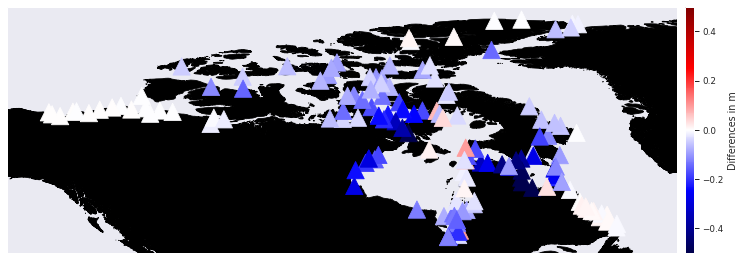

In [126]:
#compute rmsediff.
fname=fname=os.path.join(path1,'postprocessing','calibration','figures','RMSEdif_5.6-stan.jpg')
plotrmsediff(modrmse_both_6,stanmodrmse, Lonvec,Latvec,fname)

/tmp/ipykernel_26550/1863056681.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=plt.colorbar(cont,cax=cax)


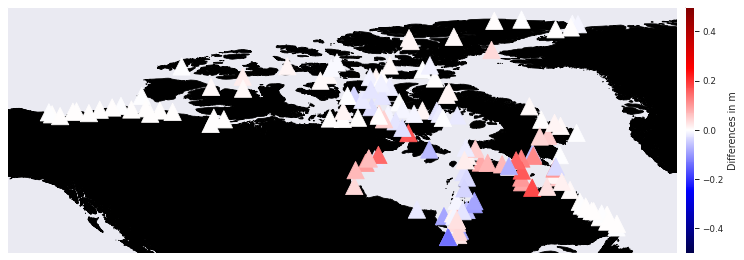

In [128]:
#compute rmsediff.
fname=fname=os.path.join(path1,'postprocessing','calibration','figures','RMSEdif_5.6-5.2.jpg')
plotrmsediff(modrmse_both_6,modrmse_both_2, Lonvec,Latvec,fname)

Comparing parameter values from runs.

In [5]:
def getparamvalue(tempparam,perparamchange,polydict):
    paramvaluevec=[]
    for keys in polydict:
        #getting points in polygon. from paramid.
        indparam=np.where(tempparam==keys)[0]
        paramvalue=perparamchange[indparam[0]]
        paramvaluevec=np.append(paramvaluevec,paramvalue)
# print(paramvaluevec)
    return(paramvaluevec)

/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_runs/snellius_runs/OpenDAruns/2020runs
Canadamodel_5.2
48
Canadamodel_5.4
44
Canadamodel_5.2
48
Canadamodel_5.4
44


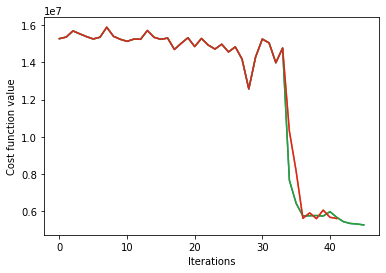

In [9]:
#function defintion. 
runsfolder=os.path.join(path1,'model_runs','snellius_runs','OpenDAruns','2020runs')
print(runsfolder)
simnamedict={'2':48,'4':44} #,

typvec=['bathy','bf']
for typ in typvec:
    if typ=='bathy':
        #bathymetry
        poldf=pd.read_csv('/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Parameters/new_bathy_polygon/bahy_polygon_vertices_v3.csv')
        poldf.head()
        Npol=17
        polydict=getparameterpolygon(poldf,Npol)
    else:
        #botomfriction
        poldf=pd.read_csv('/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_development/Openda_models/Parameters/new_bf_polygon/bf_polygon_vertices.csv')
        poldf.head()
        Npol=16
        polydict=getparameterpolygon(poldf,Npol)
    paramvaluedict={}
    for key in simnamedict:
        # if key=='5':
        simulationame='Canadamodel_5.'+key
        print(simulationame)
        CFfname='CF_'+simulationame+'.jpg'
        optworkdir=str(simnamedict[key])
        print(optworkdir)
        if typ=='bathy':
            paramfilename='bathy_correction_17_v3.xyz'
            templateparamfilename='bathy_correction_template_17_v3.xyz'
        else:
            paramfilename='bf_correction_16_v3.xyz'
            templateparamfilename='bf_correction_template_16_v3.xyz'
        
        (stdmodrmse,perparamchange_20,tempparam_20,plon_20,plat_20)=processruns(runsfolder,simulationame,CFfname,optworkdir,paramfilename,templateparamfilename)
        paramvaluevec=getparamvalue(tempparam_20,perparamchange_20,polydict)
        paramvaluedict[key]=paramvaluevec

    if typ=='bathy':
        bathyvaluedict=paramvaluedict
    else:
        bfvaluedict=paramvaluedict

In [7]:
# if typ=='bathy':
bathyparamnumber=np.linspace(1,17,17)
# else:
bfparamnumber=np.linspace(1,16,16)

2
48
4
44


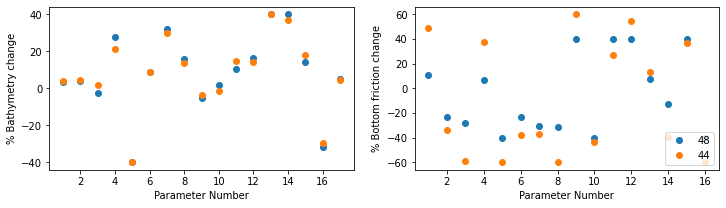

In [10]:

fig=plt.figure(figsize=(12,3))
for i in list(simnamedict.keys())[:]:
    print(i)
    print(simnamedict[i])
    plt.subplot(1,2,1)
    plt.plot(bathyparamnumber,bathyvaluedict[i],'o',label=simnamedict[i])
    plt.xlabel('Parameter Number')
    plt.ylabel('% Bathymetry change')
    plt.subplot(1,2,2)
    plt.plot(bfparamnumber,bfvaluedict[i],'o',label=simnamedict[i])
    plt.xlabel('Parameter Number')
    plt.ylabel('% Bottom friction change')
plt.legend(loc=4)

Now we compute the RMS errors betweeen TG data o/p and the optimized model. And compare that to the standard model with GTSM previous calibration and also compare to FES output. 

Now we read the standard runs from standard annual run folder. 

Now after resampling we do the comparison of all the datasets.

Now let's compute RMS for all TG.

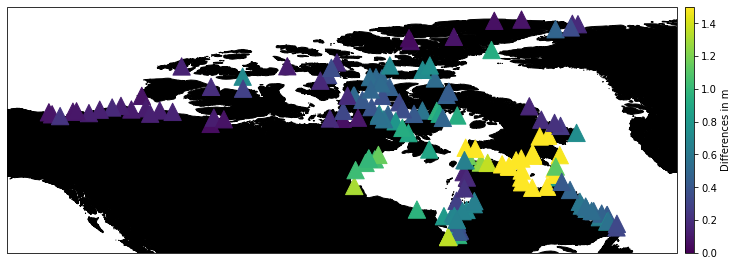

In [11]:
#Fes data
#fesdata=xr.open_dataset(os.path.join('ncdata','FESTG15min.nc'))  #after resampling
fesdata=xr.open_dataset('/u/vasulkar/p_emodnet_amey/Regional_canada_model/FESCanada/CHSTG_snapped_model_obs_09Sep.nc')
hfes=fesdata['tide']
fesrmsevec=getrmsdata(hobs,hfes.T)
fesrmsefname=os.path.join(path1,'postprocessing','calibration','figures','FES2014rmse-sep.jpg')
plotrmse(fesrmsevec,Lonvec,Latvec,fesrmsefname)

In [13]:
#gtsm data
gtsmdata=xr.open_dataset(os.path.join('ncdata','GTSMTG15min.nc'))
hgtsm=gtsmdata['H']
gtsmrmsevec=getrmsdata(hmattg,hgtsm.T)

Comparison of bathymetry

Plot the bathymetry from gtsm v4.1 and gtsm v5.0 gebco 2021 qand geb2019. 

In [5]:
#getting the bathymetry from the model net file.
netfilev4=optmodelfolder+'gtsm__canada_2_net.nc'
netdatav4=xr.open_dataset(netfilev4)
bathymetv4=netdatav4.NetNode_z.values
netxv4=netdatav4.NetNode_x.values
netyv4=netdatav4.NetNode_y.values
triangv4=readdata.gettriangulation(netxv4,netyv4)

/tmp/ipykernel_6555/3155757038.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cont)


Text(0.5, 1.0, 'Bathymetry')

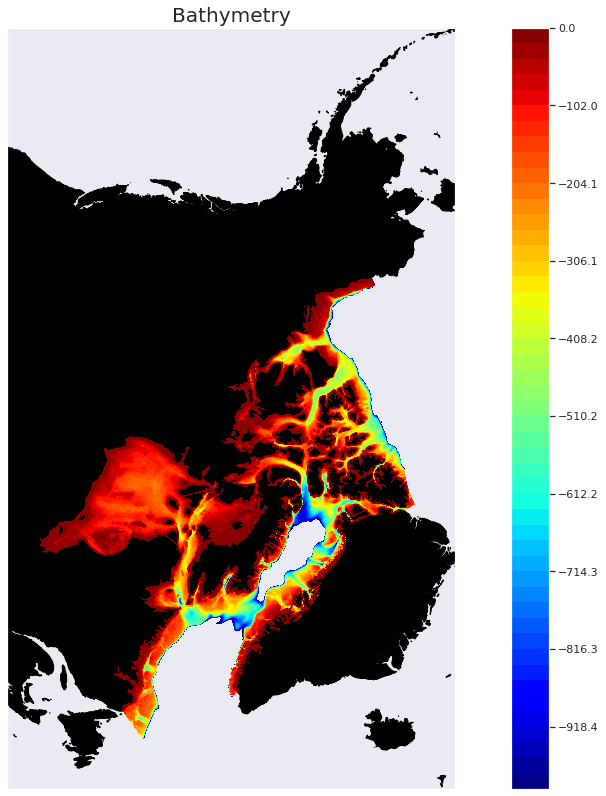

In [33]:
fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
contour_opts = {'levels': np.linspace(-1000,0,50),
                'cmap':'jet','transform':ccrs.PlateCarree()}
cont=ax1.tricontourf(triangv4,bathymetv4,**contour_opts)
fig.colorbar(cont)

plt.title('Bathymetry', fontsize=20)
# fname=os.path.join(path1,'postprocessing','calibration','figures','bathymetry.jpg')
# fig.savefig(fname,dpi=300)


In [6]:
#getting the bathymetry from the model net file.
netfilev5='/u/vasulkar/p_emodnet_amey/Regional_canada_model/bathymetry_checks/GTSM_v5_bathymetry/gtsm_200s_2000m_eu0900m_ca2000m_v4_net.nc'
netdatav5=xr.open_dataset(netfilev5)
bathymetv5=netdatav5.NetNode_z.values
netxv5=netdatav5.NetNode_x.values
netyv5=netdatav5.NetNode_y.values
triangv5=readdata.gettriangulation(netxv5,netyv5)

In [7]:
from scipy.interpolate import griddata 
interpbathyv5=griddata((netxv5,netyv5),bathymetv5,(netxv4,netyv4))


/tmp/ipykernel_6555/3926128114.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cont)


Text(0.5, 1.0, 'Bathymetry')

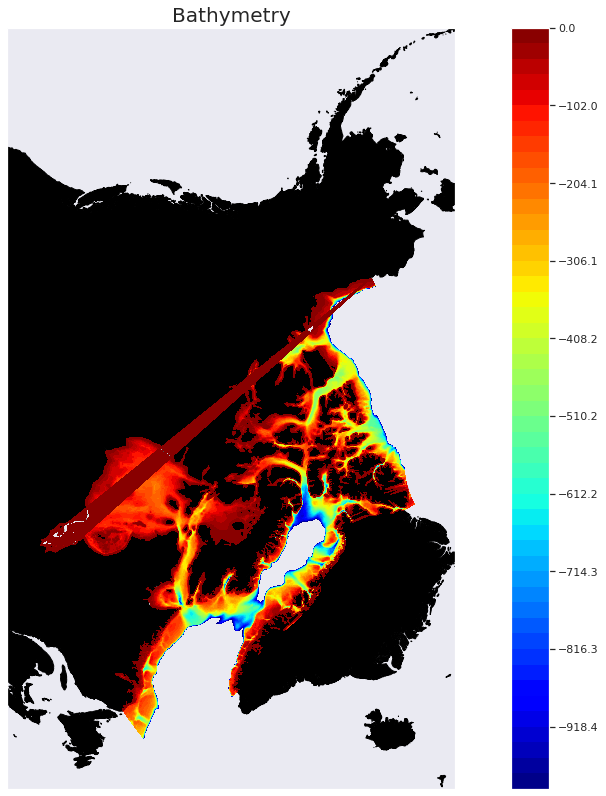

In [36]:
fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
contour_opts = {'levels': np.linspace(-1000,0,50),
                'cmap':'jet','transform':ccrs.PlateCarree()}
cont=ax1.tricontourf(triangv4,interpbathyv5,**contour_opts)
fig.colorbar(cont)

plt.title('Bathymetry', fontsize=20)
# fname=os.path.join(path1,'postprocessing','calibration','figures','bathymetry.jpg')
# fig.savefig(fname,dpi=300)

In [50]:
diffbathy=-bathymetv4+interpbathyv5
perdiffbathy=(diffbathy/bathymetv4)*100

/tmp/ipykernel_6555/2403656948.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cont)


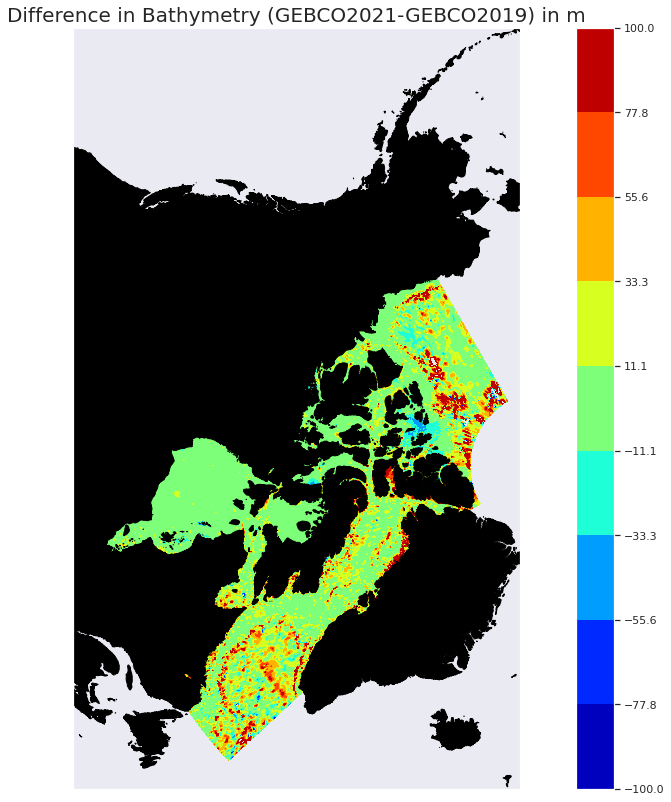

In [56]:
fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())


contour_opts = {'levels': np.linspace(-100,100,10),
                'cmap':'jet','transform':ccrs.PlateCarree()}
cont=ax1.tricontourf(triangv4,diffbathy,**contour_opts)
fig.colorbar(cont)
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
plt.title('Difference in Bathymetry (GEBCO2021-GEBCO2019) in m', fontsize=20)
# fname=os.path.join(path1,'postprocessing','calibration','figures','diff_bathymetry_19-21.jpg')
# fig.savefig(fname,dpi=300)

/tmp/ipykernel_6555/4034642473.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cont)


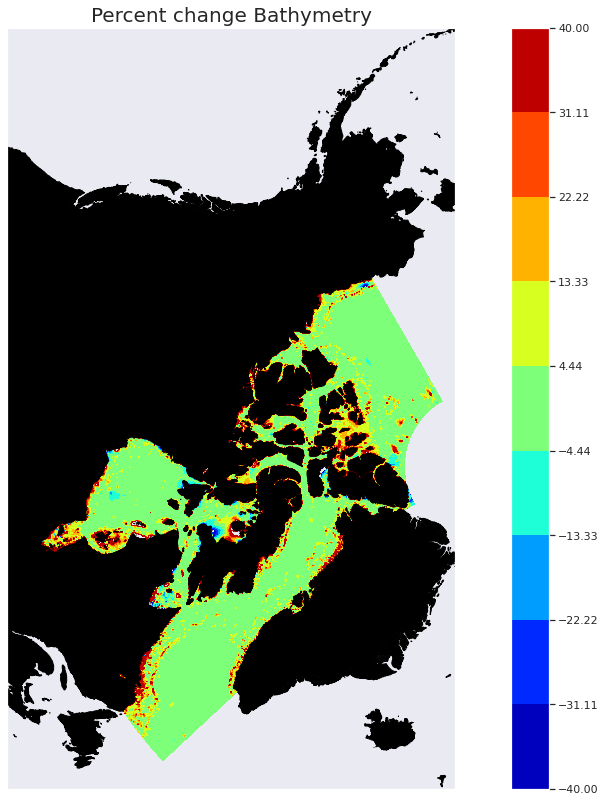

In [55]:
fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())


contour_opts = {'levels': np.linspace(-40,40,10),
                'cmap':'jet','transform':ccrs.PlateCarree()}
cont=ax1.tricontourf(triangv4,perdiffbathy,**contour_opts)
fig.colorbar(cont)
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
plt.title('Percent change Bathymetry', fontsize=20)
# fname=os.path.join(path1,'postprocessing','calibration','figures','percentdiff_bathymetry_19-21.jpg')
# fig.savefig(fname,dpi=300)

In [6]:
#reading the new gebco2021 in to our canada grid.
#getting the bathymetry from the model net file.
newnetfilev4='/u/vasulkar/p_emodnet_amey/Regional_canada_model/model_runs/h_6/gebco2021_run/DFM_interpreted_network_canada_model_dummy_net.nc'
newnetdatav4=xr.open_dataset(newnetfilev4)
newbathymetv4=newnetdatav4.NetNode_z.values
newnetxv4=newnetdatav4.NetNode_x.values
newnetyv4=newnetdatav4.NetNode_y.values
triangv4=readdata.gettriangulation(newnetxv4,newnetyv4)

In [8]:
diffbathy1=-bathymetv4+newbathymetv4
perdiffbathy1=(diffbathy1/bathymetv4)*100
# diffbathy2=-newbathymetv4+interpbathyv5
# perdiffbathy2=(diffbathy2/newbathymetv4)*100

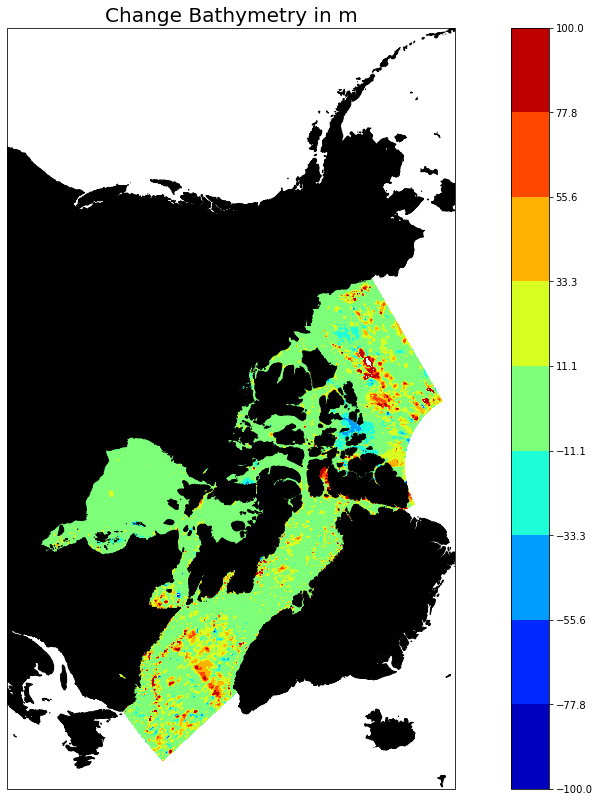

In [10]:
fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())


contour_opts = {'levels': np.linspace(-100,100,10),
                'cmap':'jet','transform':ccrs.PlateCarree()}
cont=ax1.tricontourf(triangv4,diffbathy1,**contour_opts)
fig.colorbar(cont)
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
plt.title('Change Bathymetry in m', fontsize=20)
fname=os.path.join(path1,'postprocessing','calibration','figures','diff_bathymetry_19-21_dflow.jpg')
fig.savefig(fname,dpi=300)

/tmp/ipykernel_22927/1595094546.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cont)


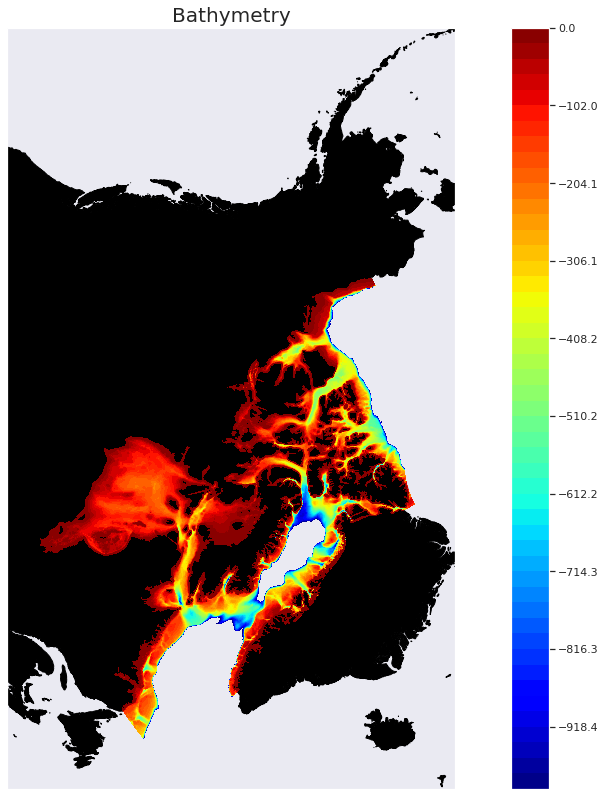

In [15]:
fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
contour_opts = {'levels': np.linspace(-1000,0,50),
                'cmap':'jet','transform':ccrs.PlateCarree()}
cont=ax1.tricontourf(triangv4,newbathymetv4,**contour_opts)
fig.colorbar(cont)

plt.title('Bathymetry', fontsize=20)
fname=os.path.join(path1,'postprocessing','calibration','figures','bathymetry_21.jpg')
fig.savefig(fname,dpi=300)

Comparison between two approaches.